In [29]:
# libraries
#%matplotlib notebook
import os

from datetime import timedelta
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn import svm


In [3]:
print(os.listdir('./Inputfile'))


dir = os.listdir('./Inputfile')
df = pd.read_csv('./Inputfile/data_engineering.csv')
df.head()

['data_engineering.csv']


,measurement_datetime,device_identifier,bytes_total,bytes_per_second,successes,failures,fetch_time
0,2019-01-05 04:57:21.000,45ce9eb2-2c36-11e7-b97c-0cc47a6bebee,369170496,36916699.0,1,0,10000095
1,2019-01-05 23:34:36.000,7b8c5fb3-9f33-11e8-ae05-002590e569f4,117293792,11717693.0,1,0,10009973
2,2019-01-05 21:15:39.000,0bebf443-9cd8-11e8-ae05-002590e569f4,372999544,37263380.0,1,0,10009815
3,2019-01-05 20:02:33.000,45ce9eb2-2c36-11e7-b97c-0cc47a6bebee,281369568,28136712.0,1,0,10000087
4,2019-01-05 06:26:41.000,485ad193-2c35-11e7-b97c-0cc47a6bebee,371844952,37181822.0,1,0,10000719


In [4]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348767 entries, 0 to 348766
Data columns (total 7 columns):
measurement_datetime    348767 non-null object
device_identifier       348767 non-null object
bytes_total             348767 non-null int64
bytes_per_second        348767 non-null float64
successes               348767 non-null int64
failures                348767 non-null int64
fetch_time              348767 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 18.6+ MB
None


In [5]:
# check the timestamp format and frequence 
print(df['measurement_datetime'].head(10))

0    2019-01-05 04:57:21.000
1    2019-01-05 23:34:36.000
2    2019-01-05 21:15:39.000
3    2019-01-05 20:02:33.000
4    2019-01-05 06:26:41.000
5    2019-01-05 10:57:30.000
6    2019-01-05 22:30:47.000
7    2019-01-05 19:16:57.000
8    2019-01-05 06:34:27.000
9    2019-01-05 14:59:14.000
Name: measurement_datetime, dtype: object


In [6]:
# check mean data exchange
print(df['bytes_total'].mean())

172862641.10516477


In [7]:
# check mean fetch time
print(df['fetch_time'].mean())

8488067.812734576


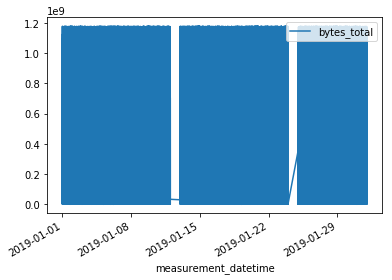

In [8]:
# change the type of timestamp column for plotting
df['measurement_datetime'] = pd.to_datetime(df['measurement_datetime'])

df['bytes_total'] = (df['bytes_total']) 
# plot the data
df.plot(x='measurement_datetime', y='bytes_total')

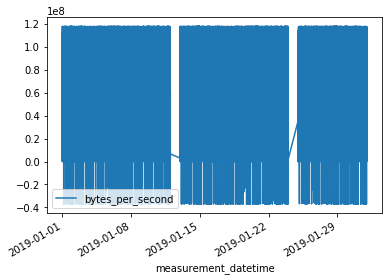

In [9]:
# change the type of timestamp column for plotting
df['measurement_datetime'] = pd.to_datetime(df['measurement_datetime'])

df['bytes_per_second'] = (df['bytes_per_second']) 
# plot the data
df.plot(x='measurement_datetime', y='bytes_per_second')

In [10]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['measurement_datetime'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [11]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['measurement_datetime'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01


In [12]:
# time with int to plot easily
df['time_epoch'] = (df['measurement_datetime'].astype(np.int64)/100000000000).astype(np.int64)

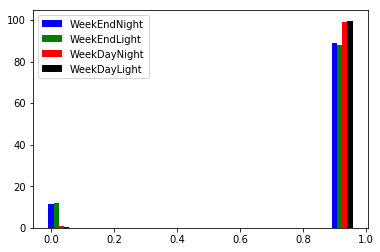

In [13]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['device_identifier'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['device_identifier'] == 0, 'successes']
b = df.loc[df['device_identifier'] == 1, 'successes']
c = df.loc[df['device_identifier'] == 2, 'successes']
d = df.loc[df['device_identifier'] == 3, 'successes']


fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()


In [14]:
# Take useful feature and standardize them
data = df[['successes', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=5)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

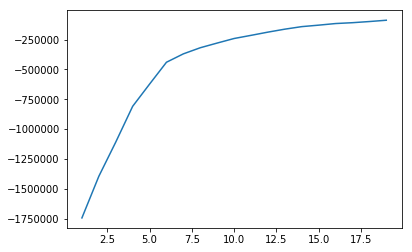

In [15]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [58]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

12    91983
13    50733
10    34655
11    34623
9     30764
1     24347
5     22623
0     22397
2     16099
3      9922
6      9025
4       894
7       702
Name: cluster, dtype: int64

In [63]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly26'] = (distance >= threshold).astype(int)

AttributeError: 'KMeans' object has no attribute 'labels'

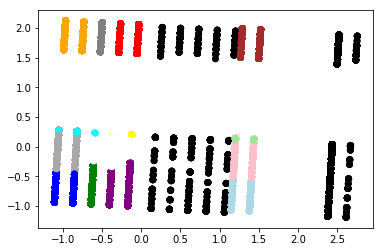

In [18]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [19]:
# Take useful feature and standardize them
data = df[['successes', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=5)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

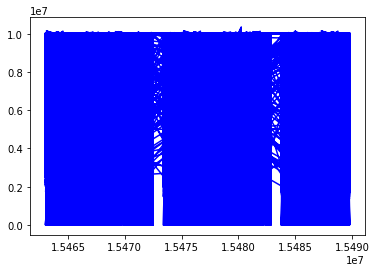

In [146]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['principal_feature1'] == 1, ['time_epoch', 'fetch_time']] #anomaly

ax.plot(df['time_epoch'], df['fetch_time'], color='blue')
ax.scatter(a['time_epoch'],a['fetch_time'], color='red')
plt.show()


In [34]:
# Take useful feature and standardize them 
data = df[['successes', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    327395
1     21372
Name: anomaly26, dtype: int64


In [57]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    clustercnt = model.labels.max()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
    #Xb = model.clustercenters[model.labels[i]-1]  ….….#distance.setvalue(i, np.linalg.norm(Xa-Xb1))
dist = []

for j in range(0,clustercnt):
    if model.labels[i] != j:
        Xb = model.clustercenters[j]
        dist.append(np.linalg.norm(Xa-Xb))
        distance.set_value(i, min(dist))
return distance



# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data,df['cluster'] )
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly26'] = (distance >= threshold).astype(int)

AttributeError: 'OneClassSVM' object has no attribute 'max'

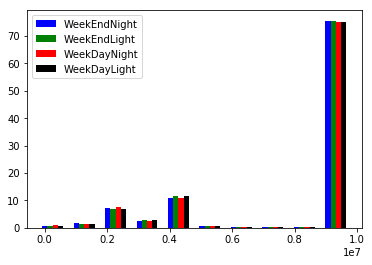

In [41]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['bytes_total'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['bytes_total'] == 0, 'fetch_time']
b = df.loc[df['bytes_total'] == 1, 'fetch_time']
c = df.loc[df['bytes_total'] == 2, 'fetch_time']
d = df.loc[df['bytes_total'] == 3, 'fetch_time']


fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()


In [42]:
# Take useful feature and standardize them
data = df[['fetch_time', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=5)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

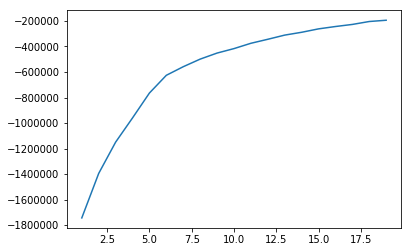

In [43]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [44]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()


0     40921
7     35455
9     34782
1     32986
13    25977
12    23631
5     22359
4     21537
14    19623
6     18457
3     16973
2     16644
8     16563
10    14019
11     8840
Name: cluster, dtype: int64

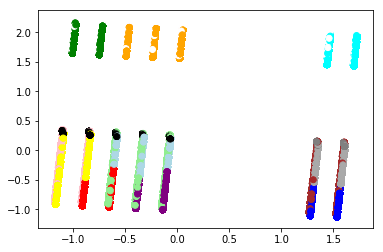

In [45]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

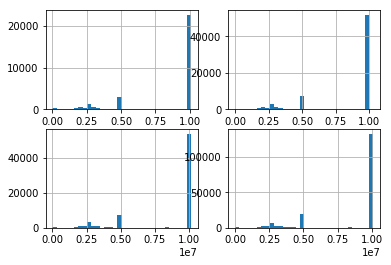

In [46]:
# plot the repartition by categories
fig, axs = plt.subplots(2,2)
a.hist(ax=axs[0,0],bins=32)
b.hist(ax=axs[0,1],bins=32)
c.hist(ax=axs[1,0],bins=32)
d.hist(ax=axs[1,1],bins=32)

In [48]:
# Take useful feature and standardize them 
data = df[['fetch_time', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly27'] = pd.Series(model.predict(data))
df['anomaly27'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly27'].value_counts())

0.0    21372
Name: anomaly27, dtype: int64


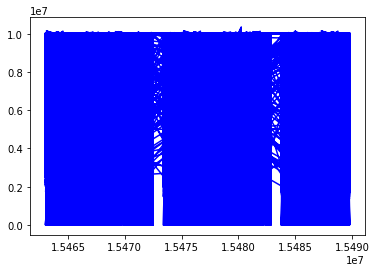

In [53]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['principal_feature1'] == 1, ['time_epoch', 'fetch_time']] #anomaly

ax.plot(df['time_epoch'], df['fetch_time'], color='blue')
ax.scatter(a['time_epoch'],a['fetch_time'], color='red')
plt.show()


KeyError: nan

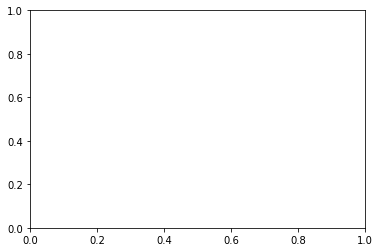

In [54]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly2"].apply(lambda x: colors[x]))
plt.show()